In [1]:
import src.service.get_data as av
import src.model.SplitData as sd
import src.model.WindowGenerator as wg
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import src.model.ComplieFit as cf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
API_KEY = "trial"
alpha_vantage = av.AlphaVantageAPI(API_KEY)
df = alpha_vantage.get_weekly_stock_prices("AAPL")

2025-02-27 07:22:55,238 - INFO - Calling URL: https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol=AAPL&apikey=CBU3HK62CDA53MJU&outputsize=full


In [3]:
split_data = sd.SplitData(df)

In [4]:
window = wg.WindowGenerator(input_width=120, label_width=5, shift=6, split_data=split_data, label_columns=['close'])
window

Total window size: 126
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [121 122 123 124 125]
Label column name(s): ['close']

In [5]:
# Stack three slices, the length of the total window.
example_window = tf.stack([
            np.array(split_data.train_df[:window.total_window_size]),
            np.array(split_data.train_df[100:100+window.total_window_size]),
            np.array(split_data.train_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 126, 5)
Inputs shape: (3, 120, 5)
Labels shape: (3, 5, 1)


In [6]:
#window.example = example_inputs, example_labels

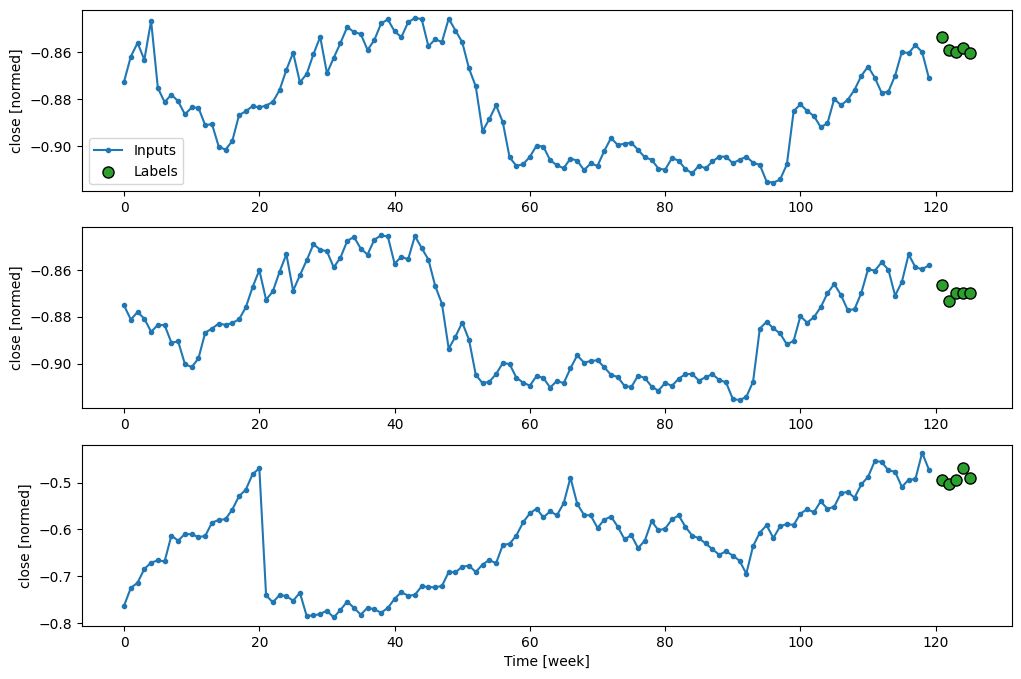

In [7]:
window.plot()

In [8]:
for example_inputs, example_labels in window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 120, 5)
Labels shape (batch, time, features): (32, 5, 1)


2025-02-27 07:22:57.092375: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
single_step_window = wg.WindowGenerator(
    input_width=1, label_width=1, shift=1,split_data=split_data,
    label_columns=['close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [10]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


2025-02-27 07:22:57.197565: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [12]:
baseline = Baseline(label_index=single_step_window.column_indices['close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mean_absolute_error: 0.0407 


In [13]:
wide_window = wg.WindowGenerator(
    input_width=24, label_width=24, shift=1, split_data = split_data,
    label_columns=['close'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

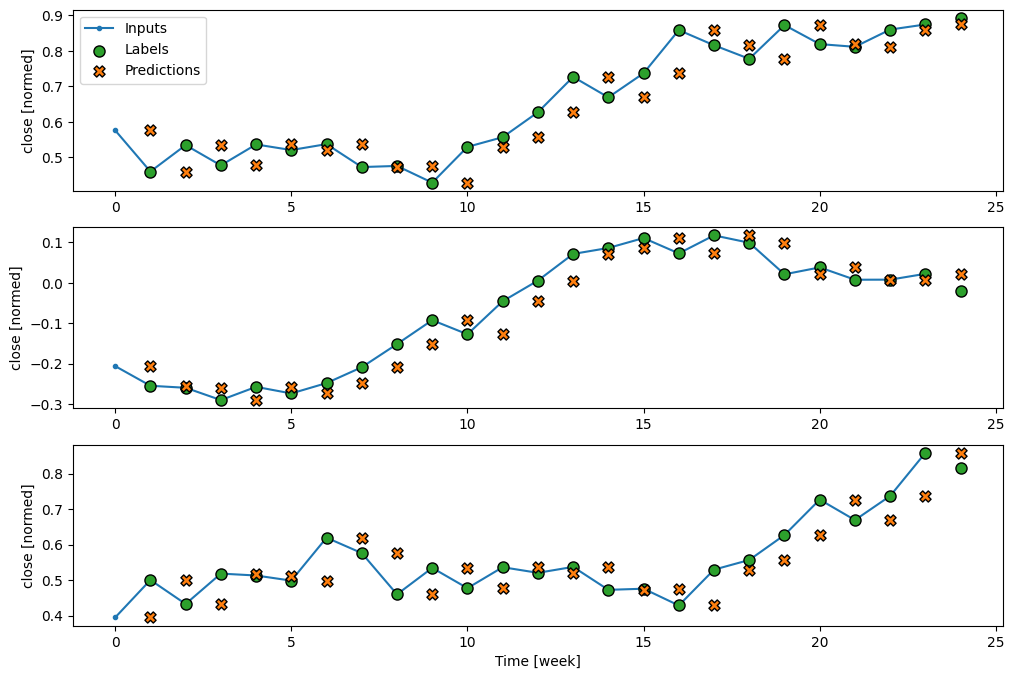

In [14]:
wide_window.plot(baseline)

In [15]:
linear = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
    ])
history = cf.compile_and_fit(linear, single_step_window)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6366 - mean_absolute_error: 1.3393 - val_loss: 6.3592 - val_mean_absolute_error: 1.9037
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4198 - mean_absolute_error: 1.2895 - val_loss: 5.9272 - val_mean_absolute_error: 1.8322
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0589 - mean_absolute_error: 1.1911 - val_loss: 5.5184 - val_mean_absolute_error: 1.7627
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8998 - mean_absolute_error: 1.1562 - val_loss: 5.1351 - val_mean_absolute_error: 1.6944
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4867 - mean_absolute_error: 1.0207 - val_loss: 4.7717 - val_mean_absolute_error: 1.6278
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3789 - mean_absolute_error: 0.9787 - val_loss: 4.4265 - val_mean_absolute_error: 1.5613
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1123 - mean_absolute_error: 0.8796 - val_loss: 4.106

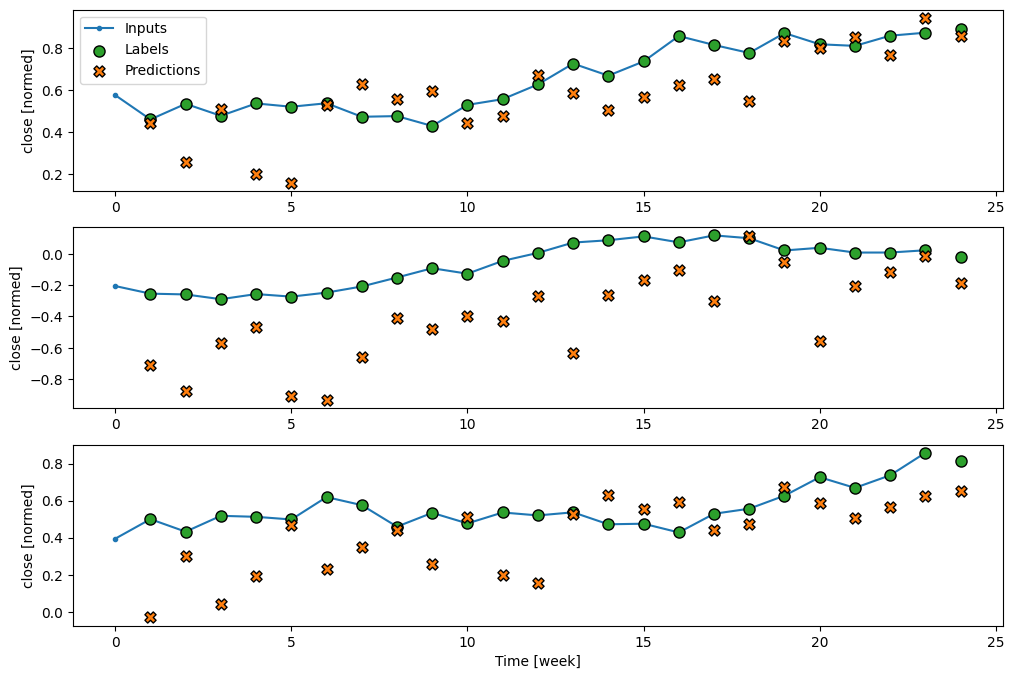

In [16]:
wide_window.plot(linear)

In [17]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = cf.compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3054 - mean_absolute_error: 0.3750 - val_loss: 0.0298 - val_mean_absolute_error: 0.0934
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - mean_absolute_error: 0.0672 - val_loss: 0.0229 - val_mean_absolute_error: 0.0608
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - mean_absolute_error: 0.0473 - val_loss: 0.0224 - val_mean_absolute_error: 0.0574
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - mean_absolute_error: 0.0480 - val_loss: 0.0223 - val_mean_absolute_error: 0.0541
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - mean_absolute_error: 0.0456 - val_loss: 0.0228 - val_mean_absolute_error: 0.0571
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - mean_absolute_error: 0.0480 - val_loss: 0.0237 - val_mean_absolute_error: 0.0613
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110 - mean_absolute_error: 0.0578 


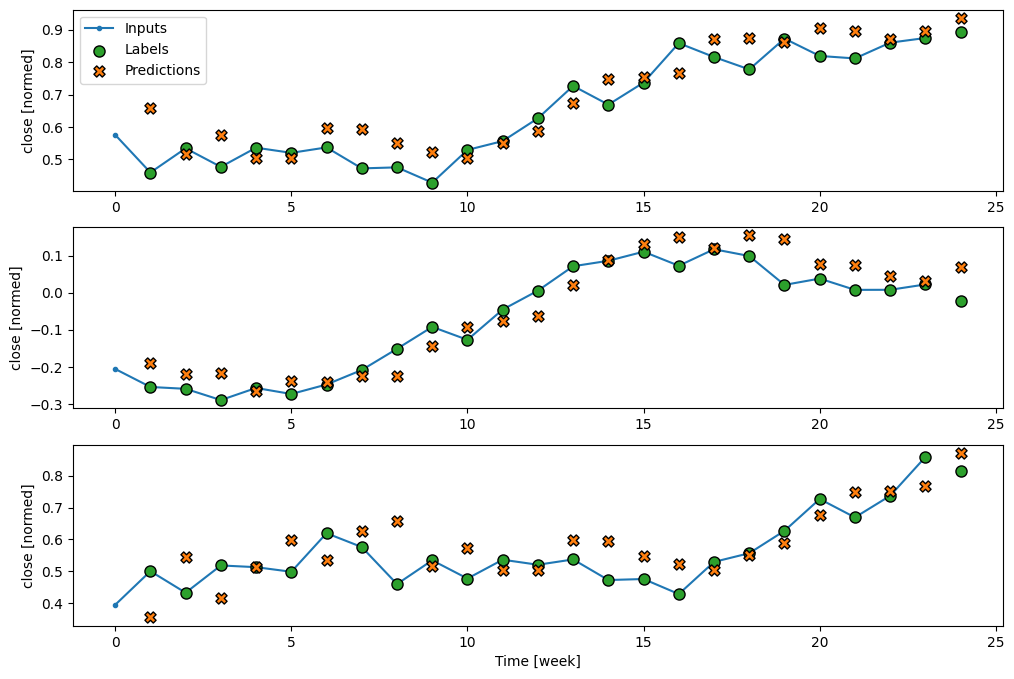

In [18]:
wide_window.plot(dense)

In [19]:
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)
val_performance['Dense']

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0498 - mean_absolute_error: 0.0716  


{'loss': 0.023719601333141327, 'mean_absolute_error': 0.06126953661441803}